<a href="https://colab.research.google.com/github/Datkhoo25/insurance_risk_prediction/blob/main/7_RFE_DT_KNN_Impute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', timeout_ms=300000)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import openpyxl
from scipy.stats import randint, uniform

from scipy.optimize import fmin_powell
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,  roc_auc_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, r2_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [ ]:
!pip install tensorflow
!pip install keras

In [ ]:
!pip install -q -U keras-tuner
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.initializers import HeNormal, GlorotNormal, LecunNormal

from keras import regularizers
from keras.layers import Dropout
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import Adam, SGD


import kerastuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner import Objective

from keras.callbacks import History
from keras.callbacks import Callback, EarlyStopping
from keras.metrics import Accuracy, Recall, Precision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.5 MB/s eta 0:00:00


<ipython-input-4-670abaa5fb26>:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
# Specify the path to your Excel file
workbook_path = '/content/drive/MyDrive/Colab Notebooks/Insurance Dataset/Preprocessing_Checkpoint/knn_Impute_wNA_dt_rfe.xlsx'

# Load the workbook
wb = openpyxl.load_workbook(workbook_path)

# Get sheet names
sheet_names = wb.sheetnames

# Container for DataFrames
dfs = {}

# Iterate through each sheet
for sheet_name in sheet_names:
    print(f"\nSheet: {sheet_name}")
    sheet = wb[sheet_name]

    # Extract headers (first row)
    headers = [cell.value for cell in sheet[1]]
    # print(f"Headers: {headers}")

    # Extract data rows
    data = []
    for row in sheet.iter_rows(min_row=2, values_only=True):
        data.append(row)
    # print("Data:")
    # for row in data:
    #     print(row)

    # Convert data to DataFrame
    df = pd.DataFrame(data, columns=headers)
    dfs[sheet_name] = df


Sheet: X_train_knn_imp_wNA_dt_rfe

Sheet: X_val_knn_imp_wNA_dt_rfe

Sheet: test_df_knn_imp_wNA_dt_rfe

Sheet: y_train

Sheet: y_val


In [ ]:
# Access your DataFrames from the dictionary `dfs`
print("\nDataFrames:")
for name, df in dfs.items():
    print(f"\nDataFrame: {name}")
    name = df

print(sheet_names)


DataFrames:

DataFrame: X_train_knn_imp_wNA_dt_rfe

DataFrame: X_val_knn_imp_wNA_dt_rfe

DataFrame: test_df_knn_imp_wNA_dt_rfe

DataFrame: y_train

DataFrame: y_val
['X_train_knn_imp_wNA_dt_rfe', 'X_val_knn_imp_wNA_dt_rfe', 'test_df_knn_imp_wNA_dt_rfe', 'y_train', 'y_val']


In [ ]:
x_train, x_val, x_test, y_train, y_val = dfs.items()
x_train_m = x_train[1]
x_val_m = x_val[1]
x_test_m = x_test[1]
y_train_m = y_train[1]
y_val_m = y_val[1]

In [ ]:
x_train = x_train_m
x_val = x_val_m
x_test = x_test_m
y_train = y_train_m
y_val = y_val_m

In [ ]:
print(x_train_m.shape, y_train_m.shape)
print(x_val_m.shape, y_val_m.shape)


(47504, 200) (47504, 1)
(11877, 200) (11877, 1)


In [ ]:
y_train_m.max()

,0
None,8


In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


SMOTE

In [ ]:
int_categorical_columns = x_train.select_dtypes(include=['int']).columns.tolist()
print(len(int_categorical_columns))

smote1 = SMOTE(sampling_strategy='not majority', random_state=42)
x_train_resampled1, y_train_resampled1 = smote1.fit_resample(x_train, y_train_encoded)

# Apply thresholding filter to integer categorical columns
for col in int_categorical_columns:
    x_train_resampled1[col] = np.where(x_train_resampled1[col] > 0.5, 1, 0)

182


In [ ]:
xgb = XGBClassifier()

ANN/DNN

In [ ]:
def build_model(hp):
    input_dim = x_train.shape[1]  # Assuming x_train is defined outside this function

    i_model = Sequential()
    i_model.add(Dense(100, input_dim=input_dim, activation='linear'))

    for each_layer in range(hp.Int("Dense Layers", min_value=1, max_value=4)):
        i_model.add(Dense(hp.Choice(f"layer_{each_layer}_filters", [30, 60, 90, 120]),
        activation=hp.Choice(f"layer_{each_layer}_activation", ['relu', 'sigmoid', 'tanh', 'linear']),
        kernel_regularizer=regularizers.l2(hp.Float("Regularizer_rate", min_value=0, max_value=0.1))))
        i_model.add(Dropout(rate=hp.Float("Dropout_rate", min_value=0, max_value=0.5)))


    i_model.add(Dense(8, activation='softmax'))

    i_model.compile(optimizer=Adam(learning_rate=0.1),
                    loss=sparse_categorical_crossentropy,
                    metrics=['accuracy'])

    return i_model

In [ ]:
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=50)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

tuner.search(x_train_resampled1, y_train_resampled1, validation_data=(x_val, y_val_encoded), epochs=40, batch_size=3, callbacks=[stop_early])



Trial 50 Complete [00h 10m 23s]
val_accuracy: 0.3243243098258972

Best val_accuracy So Far: 0.3765260577201843
Total elapsed time: 08h 23m 06s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print each hyperparameter and its value
for key, value in best_hps.values.items():
    print(f"{key}: {value}")

Dense Layers: 1
layer_0_filters: 90
layer_0_activation: linear
Regularizer_rate: 0.09342270114031029
Dropout_rate: 0.4125513680723054
layer_1_filters: 90
layer_1_activation: tanh
layer_2_filters: 60
layer_2_activation: tanh
layer_3_filters: 60
layer_3_activation: tanh


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters found: {best_hps}")

# Build and train best model
best_model = tuner.hypermodel.build(best_hps)
history1 = best_model.fit(
    x_train_resampled1,
    y_train_resampled1,
    validation_data=(x_val, y_val_encoded),
    epochs=40,
    batch_size=32,
    verbose=1,  # Ensure verbosity is set appropriately
    callbacks=[stop_early])

# Access training history
print(history1.history.keys())  # Print available metrics in history

Best hyperparameters found: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x797022f80550>


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
3910/3910 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.3075 - loss: 401.3291 - val_accuracy: 0.3753 - val_loss: 4.3196
Epoch 2/40
3910/3910 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.3511 - loss: 2.7016 - val_accuracy: 0.3768 - val_loss: 1.8307
Epoch 3/40
3910/3910 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.3063 - loss: 1251.3302 - val_accuracy: 0.3886 - val_loss: 2.3020
Epoch 4/40
3910/3910 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.3634 - loss: 9.1933 - val_accuracy: 0.1835 - val_loss: 19800.3105
Epoch 5/40
3910/3910 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.3191 - loss: 1334.3286 - val_accuracy: 0.3557 - val_loss: 1.9165
Epoch 6/40
3910/3910 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.3360 - loss: 383.6826 - val_accuracy: 0.3313 - val_loss: 2.0402
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


<Figure size 640x480 with 0 Axes>

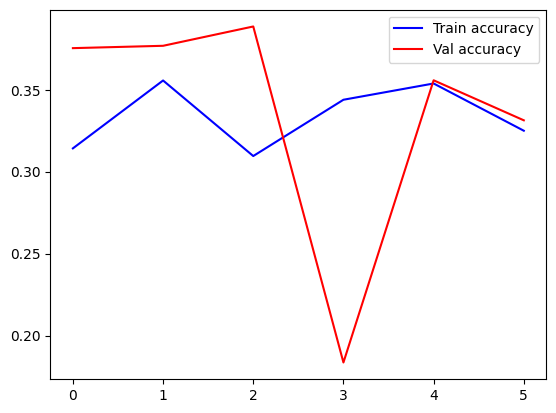

<Figure size 640x480 with 0 Axes>

In [ ]:
accuracy1 = history1.history['accuracy']
val_accuracy1 = history1.history['val_accuracy']
epochs_range1 = range(len(accuracy1))

import matplotlib.pyplot as plt

plt.plot(epochs_range1, accuracy1,'b',label='Train accuracy')
plt.plot(epochs_range1, val_accuracy1,'r',label='Val accuracy')
plt.legend()
plt.figure()



In [ ]:
# Assuming y_pred is obtained from best_model.predict(x_val)
y_pred1 = best_model.predict(x_val)

# Convert y_pred probabilities to integer labels
y_pred_labels1 = np.argmax(y_pred1, axis=1)

# Compute metrics with integer labels
accuracy1 = accuracy_score(y_val_encoded, y_pred_labels1)
print(f"Accuracy: {accuracy1}")

precision1 = precision_score(y_val_encoded, y_pred_labels1, average='micro')
print(f"Precision: {precision1}")

recall1 = recall_score(y_val_encoded, y_pred_labels1, average='micro')
print(f"Recall: {recall1}")

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters found: {best_hps}")

# Build and train best model
best_model = tuner.hypermodel.build(best_hps)
history3 = best_model.fit(
    x_train,
    y_train_encoded,
    validation_data=(x_val, y_val_encoded),
    epochs=50,
    batch_size=32,
    verbose=1,  # Ensure verbosity is set appropriately
    callbacks=[stop_early])

# Access training history
print(history3.history.keys())  # Print available metrics in history

Best hyperparameters found: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x798b38125c90>
Epoch 1/50
1485/1485 [==============================] - 4s 2ms/step - loss: 2.3875 - accuracy: 0.3252 - val_loss: 1.8209 - val_accuracy: 0.3243
Epoch 2/50
1485/1485 [==============================] - 3s 2ms/step - loss: 1.8179 - accuracy: 0.3285 - val_loss: 1.8213 - val_accuracy: 0.3243
Epoch 3/50
1485/1485 [==============================] - 3s 2ms/step - loss: 1.8170 - accuracy: 0.3292 - val_loss: 1.8187 - val_accuracy: 0.3243
Epoch 4/50
1485/1485 [==============================] - 3s 2ms/step - loss: 1.8163 - accuracy: 0.3292 - val_loss: 1.8204 - val_accuracy: 0.3243
Epoch 5/50
1485/1485 [==============================] - 3s 2ms/step - loss: 1.8176 - accuracy: 0.3284 - val_loss: 1.8312 - val_accuracy: 0.3243
Epoch 6/50
1485/1485 [==============================] - 3s 2ms/step - loss: 1.8183 - accuracy: 0.3285 - val_loss: 1.8196 - val_accuracy: 0.3243
Epoch 7/50

<Figure size 640x480 with 0 Axes>

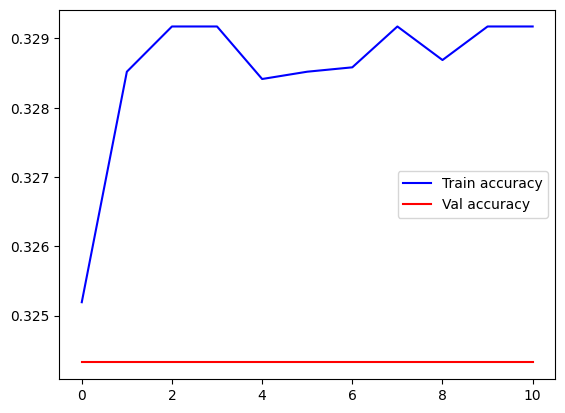

<Figure size 640x480 with 0 Axes>

In [ ]:
accuracy3 = history3.history['accuracy']
val_accuracy3 = history3.history['val_accuracy']
epochs_range3 = range(len(accuracy3))

import matplotlib.pyplot as plt

plt.plot(epochs_range3, accuracy3,'b',label='Train accuracy')
plt.plot(epochs_range3, val_accuracy3,'r',label='Val accuracy')
plt.legend()
plt.figure()

In [ ]:
# Assuming y_pred is obtained from best_model.predict(x_val)
y_pred3 = best_model.predict(x_val)

# Convert y_pred probabilities to integer labels
y_pred_labels3 = np.argmax(y_pred3, axis=1)

# Compute metrics with integer labels
accuracy3 = accuracy_score(y_val_encoded, y_pred_labels3)
print(f"Accuracy: {accuracy3}")

precision3 = precision_score(y_val_encoded, y_pred_labels3, average='micro')
print(f"Precision: {precision2}")

recall3 = recall_score(y_val_encoded, y_pred_labels3, average='micro')
print(f"Recall: {recall2}")

372/372 [==============================] - 0s 969us/step
Accuracy: 0.32432432432432434
Precision: 0.32432432432432434
Recall: 0.32432432432432434
